# Reproduce the M-Z relation from the SDSS galaxies

In [256]:
%matplotlib inline
#%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats

## parent sample created by running query to SDSS DR8

`SELECT
  i.specObjID, i.plateid, i.mjd, i.fiberid, 
  i.z, i.z_err, i.z_warning, 
  l.oii_flux, l.oii_flux_err,
  l.h_gamma_flux, l.h_gamma_flux_err,
  l.h_beta_flux, l.h_beta_flux_err,
  l.oiii_4959_flux, l.oiii_4959_flux_err,
  l.oiii_5007_flux, l.oiii_5007_flux_err,
  l.h_alpha_flux, l.h_alpha_flux_err,
  l.nii_6584_flux, l.nii_6584_flux_err,
  l.sii_6717_flux, l.sii_6717_flux_err,
  l.sii_6731_flux, l.sii_6731_flux_err, 
  e.*
FROM
  galSpecInfo i, galSpecLine l, galSpecExtra e
INTO
  mydb.MPAJHU_dr8
WHERE
  i.specObjID = l.specObjID
  AND l.specObjID = e.specObjID
  AND i.z_warning = 0
  AND i.z > 0.04
  AND i.z < 0.1
  AND l.oii_flux_err != 0
  AND l.h_beta_flux_err != 0
  AND l.oiii_5007_flux_err != 0
  AND l.h_alpha_flux_err != 0
  AND l.nii_6584_flux_err != 0
  AND l.sii_6717_flux_err != 0
  AND l.sii_6731_flux_err != 0
  AND l.oii_flux/l.oii_flux_err > 8
  AND l.h_beta_flux/l.h_beta_flux_err > 8
  AND l.oiii_5007_flux/l.oiii_5007_flux_err > 8
  AND l.h_alpha_flux/l.h_alpha_flux_err > 8
  AND l.nii_6584_flux/l.nii_6584_flux_err > 8
  AND l.sii_6717_flux/l.sii_6717_flux_err > 8
  AND l.sii_6731_flux/l.sii_6731_flux_err > 8
  AND (e.bptclass = 1 OR e.bptclass = 2)`

In [257]:
gals = pd.read_csv('MPAJHU_dr8.csv')
gals.columns.values.tolist()

['specObjID',
 'plateid',
 'mjd',
 'fiberid',
 'z',
 'z_err',
 'z_warning',
 'oii_flux',
 'oii_flux_err',
 'h_gamma_flux',
 'h_gamma_flux_err',
 'h_beta_flux',
 'h_beta_flux_err',
 'oiii_4959_flux',
 'oiii_4959_flux_err',
 'oiii_5007_flux',
 'oiii_5007_flux_err',
 'h_alpha_flux',
 'h_alpha_flux_err',
 'nii_6584_flux',
 'nii_6584_flux_err',
 'sii_6717_flux',
 'sii_6717_flux_err',
 'sii_6731_flux',
 'sii_6731_flux_err',
 'Column1',
 'bptclass',
 'oh_p2p5',
 'oh_p16',
 'oh_p50',
 'oh_p84',
 'oh_p97p5',
 'oh_entropy',
 'lgm_tot_p2p5',
 'lgm_tot_p16',
 'lgm_tot_p50',
 'lgm_tot_p84',
 'lgm_tot_p97p5',
 'lgm_fib_p2p5',
 'lgm_fib_p16',
 'lgm_fib_p50',
 'lgm_fib_p84',
 'lgm_fib_p97p5',
 'sfr_tot_p2p5',
 'sfr_tot_p16',
 'sfr_tot_p50',
 'sfr_tot_p84',
 'sfr_tot_p97p5',
 'sfr_tot_entropy',
 'sfr_fib_p2p5',
 'sfr_fib_p16',
 'sfr_fib_p50',
 'sfr_fib_p84',
 'sfr_fib_p97p5',
 'sfr_fib_entropy',
 'specsfr_tot_p2p5',
 'specsfr_tot_p16',
 'specsfr_tot_p50',
 'specsfr_tot_p84',
 'specsfr_tot_p97p5',
 'spe

In [258]:
gals.sample(10)

,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,specsfr_tot_p50,specsfr_tot_p84,specsfr_tot_p97p5,specsfr_tot_entropy,specsfr_fib_p2p5,specsfr_fib_p16,specsfr_fib_p50,specsfr_fib_p84,specsfr_fib_p97p5,specsfr_fib_entropy
8712,478569614423386112,425,51884,226,0.057427,0.000006,0,537.14120,11.618840,137.700400,...,-9.674943,-9.422750,-8.886363,-4.394871,-10.082020,-9.928594,-9.769237,-9.656302,-9.549999,-3.460767
13937,858055888106186752,762,52232,437,0.043907,0.000010,0,75.58746,6.810669,15.738210,...,-10.218190,-9.934793,-9.548147,-4.487722,-10.464180,-10.275000,-10.072440,-9.875451,-9.680625,-4.027899
10123,706069019932780544,627,52144,472,0.070103,0.000007,0,226.13310,9.052094,53.819780,...,-9.899419,-9.703548,-9.441071,-3.959702,-10.011670,-9.887477,-9.759661,-9.629535,-9.502649,-3.412840
56887,3132358896115542016,2782,54592,383,0.073346,0.000008,0,79.40907,7.621108,51.478550,...,-9.832430,-9.666475,-9.467187,-3.808278,-9.929999,-9.766483,-9.601177,-9.440205,-9.277778,-3.771899
48975,2434308369117374464,2162,54207,410,0.046738,0.000008,0,141.12950,6.647995,17.183640,...,-9.822931,-9.547150,-9.221111,-4.471747,-10.322000,-10.167390,-10.026790,-9.886942,-9.762602,-3.528402
53675,2929650176207382528,2602,54149,213,0.077762,0.000007,0,205.44230,12.002150,50.342440,...,-9.733929,-9.435472,-8.866667,-4.506196,-10.062880,-9.892126,-9.761061,-9.627136,-9.502173,-3.504587
23195,1736225405049792512,1542,53734,319,0.064217,0.000008,0,64.82797,4.764457,8.697495,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-10.175680,-9.970000,-9.782037,-9.594444,-9.418888,-3.975861
15875,1150694486150506496,1022,52524,90,0.084452,0.000006,0,136.85470,7.318804,17.637000,...,-9.266562,-8.869616,-8.408571,-4.857054,-10.028690,-9.792597,-9.631563,-9.495095,-9.369630,-3.667423
42172,2277812399262164992,2023,53851,425,0.090780,0.000007,0,342.35770,7.805334,67.968910,...,-9.457702,-9.180312,-8.704762,-4.432260,-9.682813,-9.494788,-9.292856,-9.105905,-8.943877,-3.962066
5544,447121656213694464,397,51794,507,0.043181,0.000008,0,115.95530,12.193320,64.401080,...,-9.992321,-9.806060,-9.546341,-3.945800,-10.020250,-9.875469,-9.728929,-9.580429,-9.439633,-3.594584


   ## check the distributions of variables that are used for sample selection

In [259]:
gals['oii_sn'] = gals['oii_flux']/gals['oii_flux_err']
gals['h_beta_sn'] = gals['h_beta_flux']/gals['h_beta_flux_err']
gals['oiii_5007_sn'] = gals['oiii_5007_flux']/gals['oiii_5007_flux_err']
gals['h_alpha_sn'] = gals['h_alpha_flux']/gals['h_alpha_flux_err']
gals['nii_6584_sn'] = gals['nii_6584_flux']/gals['nii_6584_flux_err']
gals['sii_6717_sn'] = gals['sii_6717_flux']/gals['sii_6717_flux_err']
gals['sii_6731_sn'] = gals['sii_6731_flux']/gals['sii_6731_flux_err']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3b79c390>,
      dtype=object)

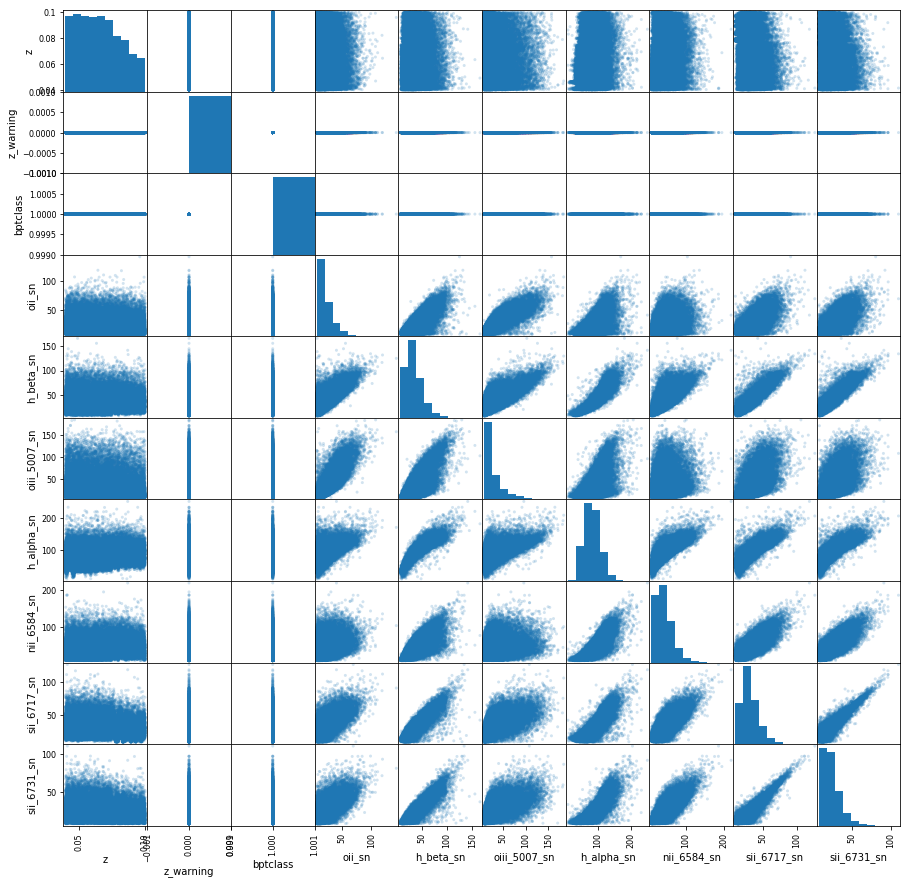

In [260]:
selected = ['z', 'z_warning', 'bptclass', \
            'oii_sn', 'h_beta_sn', 'oiii_5007_sn', 'h_alpha_sn', 'nii_6584_sn', 'sii_6717_sn', 'sii_6731_sn']
df = gals[selected]
pd.plotting.scatter_matrix(df, figsize=(15, 15), alpha=0.2)

In [261]:
df.describe()

,z,z_warning,bptclass,oii_sn,h_beta_sn,oiii_5007_sn,h_alpha_sn,nii_6584_sn,sii_6717_sn,sii_6731_sn
count,57351.000000,57351.0,57351.0,57351.000000,57351.000000,57351.000000,57351.000000,57351.000000,57351.000000,57351.000000
mean,0.065913,0.0,1.0,22.810433,35.428382,28.281452,82.000459,41.736784,30.176657,23.327822
std,0.016019,0.0,0.0,13.041072,16.684638,23.299012,25.132043,21.898472,12.671469,10.733986
min,0.040001,0.0,1.0,8.000125,8.008934,8.000280,8.323045,8.005415,8.018299,8.002653
25%,0.052292,0.0,1.0,13.452784,23.185596,12.511887,63.973976,25.254367,20.875875,15.426770
50%,0.064819,0.0,1.0,18.864270,31.993359,19.715335,80.369217,38.083732,27.682781,20.928344
75%,0.078237,0.0,1.0,28.361292,43.877360,34.911636,97.666418,54.056761,37.045166,28.803208
max,0.099991,0.0,1.0,142.122743,165.046766,183.779672,250.959849,219.286574,127.206215,109.951363


* 57351 Galaxies in total
* mean redshift 0.066
* all have z_warning = 0 and btpclass = 1 (SF)
* all seven lines used for sample selection have S/N > 8

## check the distribution of the stellar mass fraction that is covered by fiber

count    57281.000000
mean         0.391804
std          6.154750
min          0.004001
25%          0.205350
50%          0.269395
75%          0.347008
max       1027.765417
Name: fiberfrac, dtype: float64

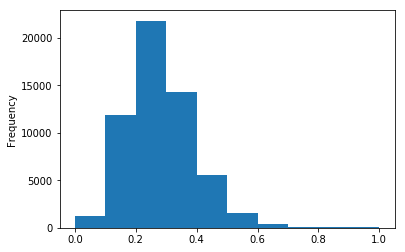

In [262]:
gals['fiberfrac'] = 10**gals['lgm_fib_p50']/10**gals['lgm_tot_p50']
gals['fiberfrac'].plot.hist(range=(0, 1))
gals['fiberfrac'].describe()

count    43848.000000
mean         0.321295
std          0.096108
min          0.200004
25%          0.249052
50%          0.300685
75%          0.369957
max          0.998121
Name: fiberfrac, dtype: float64

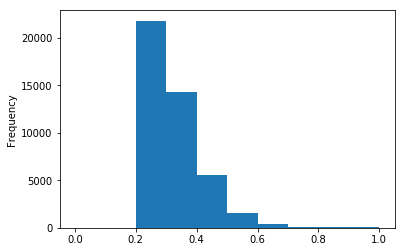

In [263]:
sample1 = gals.dropna(subset=['fiberfrac'])
sample1 = sample1[(sample1['fiberfrac'] > 0.2) & (sample1['fiberfrac'] < 1)]
sample1['fiberfrac'].plot.hist(range=(0, 1))
sample1['fiberfrac'].describe()

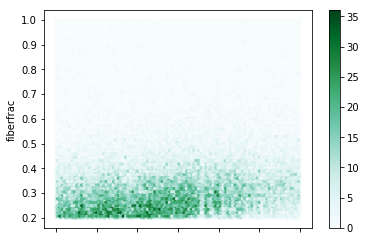

In [264]:
ax = sample1.plot.hexbin('z', 'fiberfrac')

## M-Z relation

In [265]:
sample1 = sample1[sample1['lgm_tot_p50'] != -9999.]
sample1 = sample1[sample1['oh_p50'] != -9999.]
sample1['lgm_tot_p50'].describe()

count    43805.000000
mean         9.764475
std          0.405152
min          6.680059
25%          9.506194
50%          9.776835
75%         10.042450
max         11.113010
Name: lgm_tot_p50, dtype: float64

In [266]:
sample1['oh_p50'].describe()

count    43805.000000
mean         8.838606
std          0.185849
min          7.751593
25%          8.725628
50%          8.863646
75%          8.980454
max          9.468566
Name: oh_p50, dtype: float64

## sample2 try to reproduce Kewley 2008

                            OLS Regression Results                            
Dep. Variable:                 oh_p50   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 2.072e+04
Date:                Mon, 11 Jun 2018   Prob (F-statistic):               0.00
Time:                        10:28:16   Log-Likelihood:                 31617.
No. Observations:               43638   AIC:                        -6.323e+04
Df Residuals:                   43634   BIC:                        -6.319e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

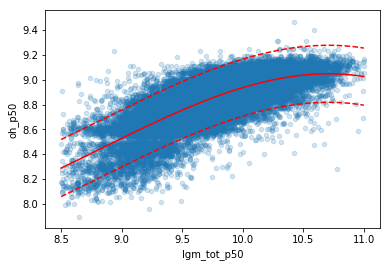

In [267]:
sample2 = sample1[(sample1['lgm_tot_p50'] > 8.5) & (sample1['lgm_tot_p50'] < 11)]
ax = sample2.plot.scatter('lgm_tot_p50', 'oh_p50', alpha=0.2)
lm = smf.ols(formula='oh_p50 ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=sample2).fit()
print(lm.summary())
X_plot = np.linspace(8.5, 11, 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(sample2['lgm_tot_p50'], iv_u)
lower = zip(sample2['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')


## select a sample to obtain metallicities

In [268]:
inlines = ['oii_flux',
 'oii_flux_err',
 'h_beta_flux',
 'h_beta_flux_err',
 'oiii_4959_flux',
 'oiii_4959_flux_err',
 'oiii_5007_flux',
 'oiii_5007_flux_err',
 'h_alpha_flux',
 'h_alpha_flux_err',
 'nii_6584_flux',
 'nii_6584_flux_err',
 'sii_6717_flux',
 'sii_6717_flux_err',
 'sii_6731_flux',
 'sii_6731_flux_err']

sample1[inlines].describe()

,oii_flux,oii_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,oiii_4959_flux_err,oiii_5007_flux,oiii_5007_flux_err,h_alpha_flux,h_alpha_flux_err,nii_6584_flux,nii_6584_flux_err,sii_6717_flux,sii_6717_flux_err,sii_6731_flux,sii_6731_flux_err
count,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04,4.380500e+04
mean,2.588867e+06,9.415866e+04,9.545154e+05,2.615744e+04,9.350631e+05,2.596725e+04,2.743847e+06,3.865169e+04,3.094750e+06,3.356578e+04,2.772340e+05,1.480962e+04,3.992815e+05,1.839110e+04,2.711748e+05,1.801400e+04
std,2.262552e+08,8.327394e+06,8.340621e+07,2.251156e+06,9.130372e+07,2.261975e+06,2.693822e+08,3.432376e+06,2.673411e+08,2.879723e+06,2.362713e+07,1.259490e+06,3.236107e+07,1.583460e+06,2.192401e+07,1.569749e+06
min,4.530242e-01,3.185838e-02,5.008117e-01,7.329396e-03,-5.072204e+01,4.885812e-03,2.638503e-01,6.224289e-03,1.961150e+00,1.604965e-02,8.026150e-01,7.929136e-03,2.919202e-01,5.655052e-03,2.113499e-01,5.148362e-03
25%,1.141728e+02,7.090604e+00,5.680684e+01,2.217512e+00,9.951413e+00,1.905649e+00,2.925346e+01,2.178383e+00,2.135447e+02,3.065821e+00,5.195101e+01,1.757476e+00,4.447260e+01,1.852239e+00,3.107494e+01,1.719572e+00
50%,1.773270e+02,9.158339e+00,9.004308e+01,2.688966e+00,1.731518e+01,2.229352e+00,5.119289e+01,2.615085e+00,3.435847e+02,4.121376e+00,9.116909e+01,2.231680e+00,6.587016e+01,2.288839e+00,4.660980e+01,2.116874e+00
75%,3.065286e+02,1.217133e+01,1.460110e+02,3.329004e+00,3.717569e+01,2.673195e+00,1.121149e+02,3.322972e+00,5.672615e+02,5.802805e+00,1.594526e+02,2.916639e+00,9.919973e+01,2.862625e+00,7.111351e+01,2.647639e+00
max,2.667911e+10,9.812136e+08,1.010463e+10,2.489606e+08,1.296624e+10,2.510583e+08,3.860543e+10,4.153716e+08,3.063032e+10,3.360025e+08,2.820167e+09,1.509299e+08,3.200651e+09,1.827775e+08,2.151761e+09,2.032551e+08


In [269]:
# exist host with oiii_4959_flux < 0
sample1['oiii_4959_sn'] = sample1['oiii_4959_flux']/sample1['oiii_4959_flux_err']
print(np.shape(sample1))
parent = sample1[sample1['oiii_4959_sn']>3]
print(np.shape(parent))
parent[inlines].describe()

(43805, 76)
(41046, 76)


,oii_flux,oii_flux_err,h_beta_flux,h_beta_flux_err,oiii_4959_flux,oiii_4959_flux_err,oiii_5007_flux,oiii_5007_flux_err,h_alpha_flux,h_alpha_flux_err,nii_6584_flux,nii_6584_flux_err,sii_6717_flux,sii_6717_flux_err,sii_6731_flux,sii_6731_flux_err
count,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04,4.104600e+04
mean,2.762877e+06,1.004872e+05,1.018671e+06,2.791550e+04,9.979151e+05,2.771255e+04,2.928279e+06,4.124960e+04,3.302754e+06,3.582174e+04,2.958629e+05,1.580493e+04,4.261169e+05,1.962715e+04,2.894002e+05,1.922471e+04
std,2.337348e+08,8.602685e+06,8.616348e+07,2.325575e+06,9.432215e+07,2.336752e+06,2.782878e+08,3.545845e+06,2.761790e+08,2.974921e+06,2.440820e+07,1.301127e+06,3.343085e+07,1.635806e+06,2.264876e+07,1.621642e+06
min,4.530242e-01,3.185838e-02,5.008117e-01,7.329396e-03,8.609197e-02,4.885812e-03,2.638503e-01,6.224289e-03,1.961150e+00,1.604965e-02,8.026150e-01,7.929136e-03,2.919202e-01,5.655052e-03,2.113499e-01,5.148362e-03
25%,1.218747e+02,7.216472e+00,5.925749e+01,2.237678e+00,1.101563e+01,1.916802e+00,3.199919e+01,2.206949e+00,2.211231e+02,3.112003e+00,5.248002e+01,1.756899e+00,4.595972e+01,1.858225e+00,3.208910e+01,1.723367e+00
50%,1.879578e+02,9.314516e+00,9.392968e+01,2.715689e+00,1.873197e+01,2.246739e+00,5.541756e+01,2.653635e+00,3.556962e+02,4.197788e+00,9.286139e+01,2.236694e+00,6.797810e+01,2.297906e+00,4.822682e+01,2.123428e+00
75%,3.195873e+02,1.238103e+01,1.511884e+02,3.370436e+00,3.979276e+01,2.700905e+00,1.201390e+02,3.388062e+00,5.859239e+02,5.924064e+00,1.631436e+02,2.934139e+00,1.020115e+02,2.875074e+00,7.335960e+01,2.657817e+00
max,2.667911e+10,9.812136e+08,1.010463e+10,2.489606e+08,1.296624e+10,2.510583e+08,3.860543e+10,4.153716e+08,3.063032e+10,3.360025e+08,2.820167e+09,1.509299e+08,3.200651e+09,1.827775e+08,2.151761e+09,2.032551e+08


('P-value for the K-S test on oh_p50 between parent and selected sample: ', 0.44217733773422635)
(40879, 76)


,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,specsfr_fib_entropy,oii_sn,h_beta_sn,oiii_5007_sn,h_alpha_sn,nii_6584_sn,sii_6717_sn,sii_6731_sn,fiberfrac,oiii_4959_sn
count,4.087900e+04,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.0,4.087900e+04,4.087900e+04,4.087900e+04,...,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000,40879.000000
mean,1.583877e+18,1406.684312,53020.561046,332.786149,0.067921,0.000007,0.0,1.243315e+06,4.959673e+04,1.846257e+05,...,-4.540505,24.178203,37.980133,30.179525,86.361914,45.413045,32.032387,24.845234,0.322349,14.216567
std,8.384527e+17,744.695290,829.316031,183.882351,0.015859,0.000002,0.0,1.500089e+08,5.876160e+06,2.169310e+07,...,98.870639,13.418554,16.614604,23.628330,24.274206,21.890399,12.728753,10.842618,0.095683,15.210655
min,2.994911e+17,266.000000,51602.000000,1.000000,0.040001,0.000002,0.0,2.363318e+01,1.866192e+00,0.000000e+00,...,-9999.000000,8.000125,8.008934,8.002295,9.229640,8.005415,8.018299,8.002653,0.200004,3.000341
25%,8.433481e+17,749.000000,52325.000000,175.000000,0.054649,0.000006,0.0,1.217745e+02,7.213056e+00,2.585289e+01,...,-3.721555,14.351410,25.808282,13.893887,69.319941,29.187207,22.735851,16.870805,0.249879,5.308167
50%,1.530232e+18,1359.000000,52976.000000,342.000000,0.067468,0.000007,0.0,1.874451e+02,9.303975e+00,4.087035e+01,...,-3.550376,20.352512,34.862367,21.600826,85.014766,42.047926,29.854167,22.704126,0.302429,8.510944
75%,2.271019e+18,2017.000000,53742.000000,493.000000,0.080258,0.000008,0.0,3.176419e+02,1.235942e+01,6.561203e+01,...,-3.390235,30.437631,46.676141,37.750453,101.209596,57.816898,39.185035,30.610922,0.371903,16.272986
max,3.348591e+18,2974.000000,54623.000000,640.000000,0.099991,0.000059,0.0,2.667911e+10,9.698221e+08,3.784883e+09,...,-1.895741,142.122743,165.046766,183.779672,250.959849,219.286574,119.173767,96.790806,0.998121,138.649388


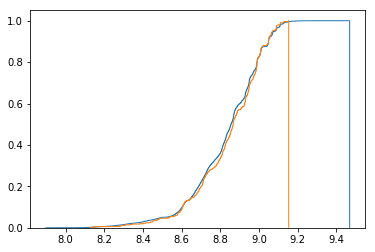

In [270]:
# only select from stellar mass 8.5 - 11 to reproduce Kewley 2008
parent0 = parent[(parent['lgm_tot_p50'] > 8.5) & (parent['lgm_tot_p50'] < 11)]
inpymcz = parent0.sample(500, random_state=0)
plt.hist(parent0['oh_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
plt.hist(inpymcz['oh_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
d, pvalue = stats.ks_2samp(parent0['oh_p50'], inpymcz['oh_p50'])
print('P-value for the K-S test on oh_p50 between parent and selected sample: ', pvalue)
print(np.shape(parent0))
parent0.describe()

('P-value for the K-S test on lgm_tot_p50 between parent and selected sample: ', 0.5829129259962508)


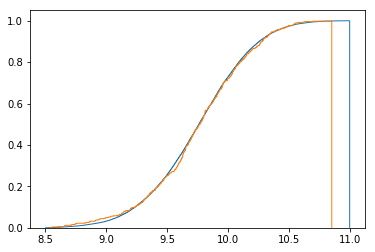

In [271]:
plt.hist(parent0['lgm_tot_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
plt.hist(inpymcz['lgm_tot_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
d, pvalue = stats.ks_2samp(parent0['lgm_tot_p50'], inpymcz['lgm_tot_p50'])
print('P-value for the K-S test on lgm_tot_p50 between parent and selected sample: ', pvalue)

('P-value for the K-S test on sfr_tot_p50 between parent and selected sample: ', 0.2520710915217092)


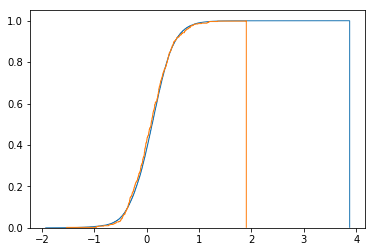

In [272]:
plt.hist(parent0['sfr_tot_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
plt.hist(inpymcz['sfr_tot_p50'], bins=1000, histtype='step', cumulative='True', normed=1)
d, pvalue = stats.ks_2samp(parent0['sfr_tot_p50'], inpymcz['sfr_tot_p50'])
print('P-value for the K-S test on sfr_tot_p50 between parent and selected sample: ', pvalue)

In [273]:
inpymcz['sfr_tot_p50'].describe()

count    500.000000
mean       0.092505
std        0.378378
min       -1.529232
25%       -0.153563
50%        0.087265
75%        0.319233
max        1.902951
Name: sfr_tot_p50, dtype: float64

                            OLS Regression Results                            
Dep. Variable:                 oh_p50   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     232.0
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           5.06e-94
Time:                        10:28:18   Log-Likelihood:                 376.02
No. Observations:                 500   AIC:                            -744.0
Df Residuals:                     496   BIC:                            -727.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

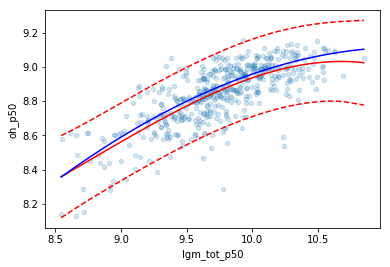

In [274]:
ax = inpymcz.plot.scatter('lgm_tot_p50', 'oh_p50', alpha=0.2)
lm = smf.ols(formula='oh_p50 ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=inpymcz).fit()
print(lm.summary())
X_plot = np.linspace(min(inpymcz['lgm_tot_p50']), max(inpymcz['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')
Y_plot = -0.694114 + X_plot*1.30207 + X_plot**2*0.00271531+ X_plot**3*(-0.00364112)
ax.plot(X_plot, Y_plot, 'b-')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(inpymcz['lgm_tot_p50'], iv_u)
lower = zip(inpymcz['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

The selected subsample of 500 galaxies can very well reproduce the Kewley 2008, M-Z relation in the T04 calibration.

## Output line fluxes for calculation

In [275]:
# attach a column that denote the order of input to pymcz
inpymcz['inkey'] = np.arange(1,501)
inpymcz.head(10)
inpymcz.tail(10)

,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,oii_sn,h_beta_sn,oiii_5007_sn,h_alpha_sn,nii_6584_sn,sii_6717_sn,sii_6731_sn,fiberfrac,oiii_4959_sn,inkey
27867,1051632064383707136,934,52672,151,0.057042,0.000009,0,115.25770,9.447333,14.07961,...,12.200025,17.504082,12.626643,50.896037,19.259529,17.097059,13.830535,0.200497,4.622028,491
4318,438104011615266816,389,51795,469,0.064835,0.000007,0,405.61640,10.378020,93.43243,...,39.084180,58.631707,47.879473,112.510905,70.736229,46.335526,37.458339,0.389351,20.045437,492
54201,2948765466723641344,2619,54506,122,0.095237,0.000007,0,62.52636,7.707777,23.81542,...,8.112113,24.666605,9.120194,69.083612,39.679889,17.113355,11.464195,0.404390,3.802750,493
1080,323271570791360512,287,52023,503,0.082152,0.000006,0,543.00230,10.014120,80.95539,...,54.223666,63.364658,73.497370,141.055229,61.401676,48.902378,28.098553,0.350863,36.776141,494
38684,2387015069515933696,2120,53852,390,0.082311,0.000007,0,127.40700,9.363541,39.25808,...,13.606711,31.982545,12.213660,80.875375,47.180828,26.556231,16.748066,0.236048,4.811955,495
46210,2726993139888842752,2422,54096,231,0.055701,0.000008,0,110.72940,9.903577,22.35297,...,11.180748,20.383521,13.446099,58.704906,22.757906,19.926454,13.024843,0.248200,4.939341,496
54301,2493980782356359168,2215,53793,409,0.064943,0.000006,0,244.20360,6.059005,36.73488,...,40.304241,42.256105,50.116924,85.046070,35.293351,33.877184,24.702117,0.540045,26.037765,497
55890,3101912318204733440,2755,54507,211,0.065850,0.000008,0,318.37900,20.617440,92.76801,...,15.442218,53.614946,25.069705,108.277604,84.747659,53.382046,42.248200,0.412437,10.842171,498
39281,1597717716377036800,1419,53144,239,0.050704,0.000010,0,81.08314,8.356338,21.41224,...,9.703191,21.780606,12.359256,56.623941,28.371036,19.919738,14.499477,0.333350,3.329510,499
9229,529296133881620480,470,51929,448,0.052050,0.000007,0,156.20960,7.492036,33.29293,...,20.850087,24.467426,17.212374,74.194475,45.089135,28.546981,21.907438,0.437400,8.282299,500


In [276]:
inpymcz.describe()

,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,oii_sn,h_beta_sn,oiii_5007_sn,h_alpha_sn,nii_6584_sn,sii_6717_sn,sii_6731_sn,fiberfrac,oiii_4959_sn,inkey
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.589823e+18,1411.968000,53041.352000,322.916000,0.066907,0.000007,0.0,249.413678,10.808464,51.567536,...,22.831512,36.613152,28.290480,84.790853,45.113036,31.446047,24.228711,0.326039,13.033860,250.500000
std,8.345182e+17,741.202448,829.135687,182.566695,0.016029,0.000002,0.0,210.043648,5.923177,41.374446,...,11.788429,14.955945,21.172738,22.577986,21.028510,11.219011,9.916720,0.095887,12.882636,144.481833
min,3.075112e+17,273.000000,51614.000000,2.000000,0.040053,0.000004,0.0,49.746010,2.906986,7.216729,...,8.112113,8.828465,8.004659,27.328613,9.141449,9.409806,8.114120,0.200497,3.035348,1.000000
25%,8.397738e+17,745.750000,52319.250000,168.500000,0.053646,0.000006,0.0,123.056000,7.220097,25.595673,...,14.240473,25.649243,13.661310,68.876413,29.172963,23.187421,16.725252,0.255058,5.316922,125.750000
50%,1.555496e+18,1381.500000,53052.500000,334.500000,0.066278,0.000007,0.0,182.418550,9.368389,40.265685,...,19.818649,34.531865,20.948871,85.121440,41.900437,29.936973,22.647302,0.306615,8.193164,250.500000
75%,2.284247e+18,2028.750000,53768.500000,486.000000,0.078832,0.000008,0.0,303.337375,12.459862,64.678263,...,28.211468,45.078027,34.881264,99.378608,58.065791,38.169714,30.503093,0.375401,15.204101,375.250000
max,3.328214e+18,2956.000000,54585.000000,639.000000,0.099020,0.000032,0.0,1786.245000,50.140180,322.643000,...,74.363177,113.080442,130.301087,172.855585,142.076483,77.915328,66.089762,0.900868,80.854114,500.000000


In [277]:
infile1 = open('ptf_slsn_meas.txt', 'w')
infile2 = open('ptf_slsn_err.txt', 'w')

line = r';# galnum,[OII]3727,Hb,[OIII]4959,[OIII]5007,[OI]6300,Ha,[NII]6584,[SII]6717,[SII]6731,[SIII]9069,[SIII]9532'+'\n'
infile1.write(line)
infile2.write(line)

print(inpymcz.iloc[0])

for i in range(len(inpymcz)):
    line = str(int(inpymcz.iloc[i]['inkey']))+'.  '
    line = line + str(round(inpymcz.iloc[i]['oii_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['h_beta_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['oiii_4959_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['oiii_5007_flux'],4)) + '  nan  '
    line = line + str(round(inpymcz.iloc[i]['h_alpha_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['nii_6584_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['sii_6717_flux'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['sii_6731_flux'],4)) + '  '
    line = line + '  nan  nan\n'
    #print(line)
    infile1.write(line)
    
    line = str(int(inpymcz.iloc[i]['inkey']))+'.  '
    line = line + str(round(inpymcz.iloc[i]['oii_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['h_beta_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['oiii_4959_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['oiii_5007_flux_err'],4)) + '  0.000  '
    line = line + str(round(inpymcz.iloc[i]['h_alpha_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['nii_6584_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['sii_6717_flux_err'],4)) + '  '
    line = line + str(round(inpymcz.iloc[i]['sii_6731_flux_err'],4)) + '  '
    line = line + '  0.000  0.000\n'
    #print(line)
    infile2.write(line)
    
infile1.close()
infile2.close()

specObjID              1.379315e+18
plateid                1.225000e+03
mjd                    5.276000e+04
fiberid                3.190000e+02
z                      8.639113e-02
z_err                  9.545402e-06
z_warning              0.000000e+00
oii_flux               9.340969e+01
oii_flux_err           8.266558e+00
h_gamma_flux           2.911529e+01
h_gamma_flux_err       3.530676e+00
h_beta_flux            5.997379e+01
h_beta_flux_err        3.225969e+00
oiii_4959_flux         1.533014e+01
oiii_4959_flux_err     3.119154e+00
oiii_5007_flux         4.216482e+01
oiii_5007_flux_err     3.371760e+00
h_alpha_flux           3.404039e+02
h_alpha_flux_err       4.935653e+00
nii_6584_flux          1.309144e+02
nii_6584_flux_err      3.347852e+00
sii_6717_flux          6.825485e+01
sii_6717_flux_err      3.378091e+00
sii_6731_flux          4.121686e+01
sii_6731_flux_err      3.466649e+00
Column1                1.379315e+18
bptclass               1.000000e+00
oh_p2p5                8.869

In [278]:
inpymcz.to_pickle('inpymcz.pkl')

## Run pyMCZ on pymcz_meas.txt and pymcz_err.txt

On astro9:

`
cd /data/sh162/NYU/pyMCZ
ur_setup
python pyMCZ/mcz.py pymcz 2000 --path /data/sh162/NYU/pyMCZ --md D13all,KD02,PP04,M08 --asciiout
`

Pull out all relavent results by running

`
grep D13_N2S2_O3S2 pymcz_n2000*.txt > pymcz_all.txt
grep KD02comb pymcz_n2000*.txt >> pymcz_all.txt
grep PP04_O3N2 pymcz_n2000*.txt >> pymcz_all.txt
grep M08_N2Ha pymcz_n2000*.txt >> pymcz_all.txt
`

Copy file `/data/sh162/NYU/pyMCZ/output/pymcz/pymcz_all.txt`

## Extract metallicities from pyMCZ measurements

In [279]:
outpymcz = pd.read_csv('pymcz_all.txt', delimiter='\t', names=['name', 'p50', 'p16', 'p84'])
outpymcz.head()


,name,p50,p16,p84
0,ptf_slsn_n2000_1.txt:M13_O3N2,8.493,0.013,0.014
1,ptf_slsn_n2000_10.txt:M13_O3N2,8.441,0.008,0.009
2,ptf_slsn_n2000_100.txt:M13_O3N2,8.539,0.013,0.013
3,ptf_slsn_n2000_101.txt:M13_O3N2,8.508,0.011,0.011
4,ptf_slsn_n2000_102.txt:M13_O3N2,8.564,0.016,0.015


In [280]:
import re
outpymcz['inkey'] = outpymcz['name'].apply(lambda k: int(re.findall(r'ptf_slsn_n2000_(\d+).txt:\w+', k)[0]))
outpymcz['calibration'] = outpymcz['name'].apply(lambda k: str(re.findall(r'ptf_slsn_n2000_\d+.txt:(\w+)', k)[0]))
outpymcz.head()

,name,p50,p16,p84,inkey,calibration
0,ptf_slsn_n2000_1.txt:M13_O3N2,8.493,0.013,0.014,1,M13_O3N2
1,ptf_slsn_n2000_10.txt:M13_O3N2,8.441,0.008,0.009,10,M13_O3N2
2,ptf_slsn_n2000_100.txt:M13_O3N2,8.539,0.013,0.013,100,M13_O3N2
3,ptf_slsn_n2000_101.txt:M13_O3N2,8.508,0.011,0.011,101,M13_O3N2
4,ptf_slsn_n2000_102.txt:M13_O3N2,8.564,0.016,0.015,102,M13_O3N2


In [281]:
outpymcz['name'].apply(lambda k: int(re.findall(r'ptf_slsn_n2000_(\d+).txt:\w+', k)[0]))

0         1
1        10
2       100
3       101
4       102
5       103
6       104
7       105
8       106
9       107
10      108
11      109
12       11
13      110
14      111
15      112
16      113
17      114
18      115
19      116
20      117
21      118
22      119
23       12
24      120
25      121
26      122
27      123
28      124
29      125
       ... 
1968     72
1969     73
1970     74
1971     75
1972     76
1973     77
1974     78
1975     79
1976      8
1977     80
1978     81
1979     82
1980     83
1981     84
1982     85
1983     86
1984     87
1985     88
1986     89
1987      9
1988     90
1989     91
1990     92
1991     93
1992     94
1993     95
1994     96
1995     97
1996     98
1997     99
Name: name, Length: 1998, dtype: int64

In [282]:
#D13s = outpymcz[outpymcz['calibration'] == 'D13_N2S2_O3S2'][['p50', 'p16', 'p84', 'inkey']]
KD02s = outpymcz[outpymcz['calibration'] == 'KD02comb'][['p50', 'p16', 'p84', 'inkey']]
PP04s = outpymcz[outpymcz['calibration'] == 'PP04_O3N2'][['p50', 'p16', 'p84', 'inkey']]
M08s = outpymcz[outpymcz['calibration'] == 'M08_N2Ha'][['p50', 'p16', 'p84', 'inkey']]
M13s = outpymcz[outpymcz['calibration'] == 'M13_O3N2'][['p50', 'p16', 'p84', 'inkey']]
#result = pd.merge(inpymcz, D13s, how='left', on='inkey')
result = pd.merge(inpymcz, KD02s, how='left', on='inkey')
#result = pd.merge(result, KD02s, how='left', on='inkey', suffixes=('', '_KD02comb'))
result = pd.merge(result, PP04s, how='left', on='inkey', suffixes=('', '_PP04_O3N2'))
result = pd.merge(result, M08s, how='left', on='inkey', suffixes=('', '_M08_N2Ha'))
result = pd.merge(result, M13s, how='left', on='inkey', suffixes=('', '_M13_O3N2'))
#result = result.rename(columns={'p50':'p50_D13_N2S2_O3S2', 'p16':'p16_D13_N2S2_O3S2', 'p84':'p84_D13_N2S2_O3S2'})
result = result.rename(columns={'p50':'p50_KD02comb', 'p16':'p16_KD02comb', 'p84':'p84_KD02comb'})
result.head()

,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,p84_KD02comb,p50_PP04_O3N2,p16_PP04_O3N2,p84_PP04_O3N2,p50_M08_N2Ha,p16_M08_N2Ha,p84_M08_N2Ha,p50_M13_O3N2,p16_M13_O3N2,p84_M13_O3N2
0,1379315118239672320,1225,52760,319,0.086391,0.000010,0,93.40969,8.266558,29.11529,...,0.030,8.670,0.013,0.014,9.034,0.017,0.018,8.493,0.013,0.014
1,680098554194192384,604,52079,200,0.069204,0.000005,0,456.90930,14.822810,80.63847,...,0.016,8.542,0.005,0.005,8.829,0.008,0.009,8.408,0.006,0.006
2,472953583688509440,420,51871,275,0.040612,0.000007,0,133.15340,9.322999,15.93581,...,0.062,8.357,0.014,0.013,8.546,0.030,0.027,8.284,0.010,0.009
3,693703091391850496,616,52374,541,0.044110,0.000010,0,143.96140,13.413150,21.76315,...,0.043,8.595,0.019,0.017,8.865,0.028,0.032,8.442,0.014,0.014
4,642980969258706944,571,52286,335,0.066167,0.000008,0,96.99915,5.471032,33.54151,...,0.016,8.785,0.012,0.014,8.999,0.011,0.011,8.570,0.016,0.017


In [283]:
result['p50_KD02comb']

0      8.907
1      8.808
2      8.497
3      8.862
4      9.019
5      9.010
6      9.014
7      8.730
8      8.824
9      8.845
10     8.941
11     8.726
12     8.977
13     8.605
14     8.933
15     8.942
16     9.067
17     8.663
18     8.869
19     8.904
20     9.076
21     8.698
22     8.798
23     8.903
24     8.830
25     8.924
26     8.860
27     8.903
28     8.855
29     9.089
       ...  
470    8.660
471    8.962
472    8.661
473    8.611
474    8.710
475    9.026
476    8.939
477    8.696
478    8.584
479    8.975
480    8.949
481    8.907
482    8.794
483    8.776
484    8.761
485    8.758
486    8.866
487    8.555
488    8.903
489    8.762
490    8.809
491    8.911
492    9.032
493    8.739
494    8.973
495    8.841
496    8.746
497    8.936
498    8.968
499    8.989
Name: p50_KD02comb, Length: 500, dtype: float64

The dataframe 'result' contains the pyMCZ metallicities for 500 SDSS galaxies!

## Fit for average trends and prediction intervals for four calibrations

                            OLS Regression Results                            
Dep. Variable:          p50_PP04_O3N2   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     202.5
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.01e-85
Time:                        10:28:20   Log-Likelihood:                 474.00
No. Observations:                 500   AIC:                            -940.0
Df Residuals:                     496   BIC:                            -923.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

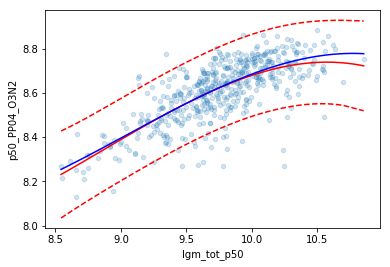

In [284]:
intervals = {}

ax = result.plot.scatter('lgm_tot_p50', 'p50_PP04_O3N2', alpha=0.2)
lm = smf.ols(formula='p50_PP04_O3N2 ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')

intervals['PP04_x'] = [x for x in X_plot]
intervals['PP04_y'] = [y for y in Y_plot]
Y_plot = 32.1488 + X_plot*(-8.51258) + X_plot**2*0.976384+ X_plot**3*(-0.0359763)
ax.plot(X_plot, Y_plot, 'b-')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')
intervals['PP04_ux'] = [x[0] for x in upper_sorted]
intervals['PP04_uy'] = [x[1] for x in upper_sorted]
intervals['PP04_lx'] = [x[0] for x in lower_sorted]
intervals['PP04_ly'] = [x[1] for x in lower_sorted]

ax = result.plot.scatter('lgm_tot_p50', 'p50_D13_N2S2_O3S2', alpha=0.2)
lm = smf.ols(formula='p50_D13_N2S2_O3S2 ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')
intervals['D13_x'] = [x for x in X_plot]
intervals['D13_y'] = [y for y in Y_plot]

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')
intervals['D13_ux'] = [x[0] for x in upper_sorted]
intervals['D13_uy'] = [x[1] for x in upper_sorted]
intervals['D13_lx'] = [x[0] for x in lower_sorted]
intervals['D13_ly'] = [x[1] for x in lower_sorted]




                            OLS Regression Results                            
Dep. Variable:           p50_KD02comb   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     207.9
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           2.66e-87
Time:                        10:28:21   Log-Likelihood:                 452.79
No. Observations:                 500   AIC:                            -897.6
Df Residuals:                     496   BIC:                            -880.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

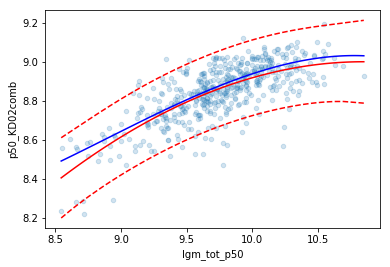

In [285]:
ax = result.plot.scatter('lgm_tot_p50', 'p50_KD02comb', alpha=0.2)
lm = smf.ols(formula='p50_KD02comb ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')
intervals['KD02_x'] = [x for x in X_plot]
intervals['KD02_y'] = [y for y in Y_plot]
Y_plot = 28.0974 + X_plot*(-7.23631) + X_plot**2*0.850344+ X_plot**3*(-0.0318315)
ax.plot(X_plot, Y_plot, 'b-')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')
intervals['KD02_ux'] = [x[0] for x in upper_sorted]
intervals['KD02_uy'] = [x[1] for x in upper_sorted]
intervals['KD02_lx'] = [x[0] for x in lower_sorted]
intervals['KD02_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:           p50_M08_N2Ha   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     212.0
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.06e-86
Time:                        10:28:21   Log-Likelihood:                 454.37
No. Observations:                 470   AIC:                            -900.7
Df Residuals:                     466   BIC:                            -884.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

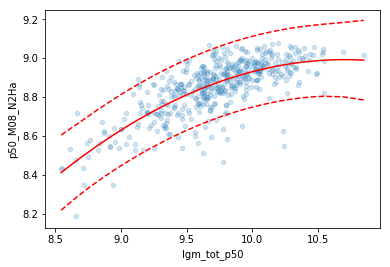

In [286]:
temp = result
result = result[result['p50_M08_N2Ha'] < 9.2]
ax = result.plot.scatter('lgm_tot_p50', 'p50_M08_N2Ha', alpha=0.2)
lm = smf.ols(formula='p50_M08_N2Ha ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')
intervals['M08_x'] = [x for x in X_plot]
intervals['M08_y'] = [y for y in Y_plot]

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')
intervals['M08_ux'] = [x[0] for x in upper_sorted]
intervals['M08_uy'] = [x[1] for x in upper_sorted]
intervals['M08_lx'] = [x[0] for x in lower_sorted]
intervals['M08_ly'] = [x[1] for x in lower_sorted]

The subsample of 500 SDSS galaxies can very well reproduce the Kewley 2008 M-Z relation for the KD02comb and PP04_O3N2 calibrations. 

However, there are a bunch of outliers in the M08_N2Ha cabration that have been excluded from the M-Z fitting. 

Use the following dictionary to overlay the SDSS M-Z relation on other plots.

                            OLS Regression Results                            
Dep. Variable:           p50_M13_O3N2   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     161.3
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.31e-71
Time:                        10:28:21   Log-Likelihood:                 634.02
No. Observations:                 468   AIC:                            -1260.
Df Residuals:                     464   BIC:                            -1243.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

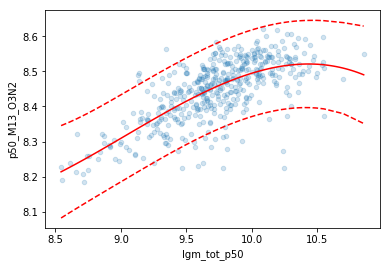

In [287]:
temp = result
result = result[result['p50_M13_O3N2'] < 9.2]
ax = result.plot.scatter('lgm_tot_p50', 'p50_M13_O3N2', alpha=0.2)
lm = smf.ols(formula='p50_M13_O3N2 ~ lgm_tot_p50 + np.power(lgm_tot_p50, 2) + np.power(lgm_tot_p50, 3)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='red')
intervals['M13_x'] = [x for x in X_plot]
intervals['M13_y'] = [y for y in Y_plot]

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')
intervals['M13_ux'] = [x[0] for x in upper_sorted]
intervals['M13_uy'] = [x[1] for x in upper_sorted]
intervals['M13_lx'] = [x[0] for x in lower_sorted]
intervals['M13_ly'] = [x[1] for x in lower_sorted]

In [288]:
intervals.keys()

['PP04_lx',
 'PP04_ly',
 'M08_y',
 'M08_x',
 'PP04_y',
 'PP04_x',
 'KD02_x',
 'KD02_y',
 'M13_uy',
 'M13_ux',
 'M13_y',
 'M13_x',
 'M08_uy',
 'M08_ux',
 'KD02_ly',
 'KD02_lx',
 'KD02_ux',
 'KD02_uy',
 'M08_lx',
 'M08_ly',
 'PP04_uy',
 'PP04_ux',
 'M13_lx',
 'M13_ly']

In [289]:
import pickle
pickle.dump(intervals, open('intervals.pkl', 'wb'))

In [290]:
file3 = open('intervals.txt', 'w')
for key in intervals.keys():
    file3.write('\n'+key+'\n')
    file3.write(str(intervals[key]))
file3.close()

In [291]:
# read the values from intervals.txt into a dictionary for plotting purpose
test = {}
file4 = open('intervals.txt', 'r')
lines = file4.readlines()
flag = 0
for line in lines:
    if re.search(r'[a-zA-Z]+\d+_[a-zA-Z]+', line):
        key = line[:-1]
        flag = 0
    if line.startswith('['):
        line = line[1:-2]
        vals = line.split(r', ')
        vals = [float(val) for val in vals]
        flag = 1
    if flag:
        test[key] = vals
#print(test)
file4.close()

## SFR vs. Stellar mass relation for the SDSS galaxies

                            OLS Regression Results                            
Dep. Variable:            sfr_tot_p50   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     407.3
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.38e-65
Time:                        10:28:21   Log-Likelihood:                -35.026
No. Observations:                 469   AIC:                             74.05
Df Residuals:                     467   BIC:                             82.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -5.8843      0.295    -19.931      

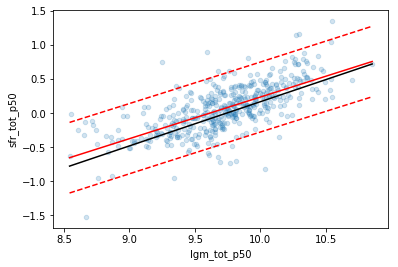

In [292]:
sfsq = {}

result = temp
result = result[result['sfr_tot_p50'] < 1.5] # only one gal is eliminated!!!
ax = result.plot.scatter('lgm_tot_p50', 'sfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='sfr_tot_p50 ~ lgm_tot_p50', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['lgm_tot_p50']), max(result['lgm_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['lgm_tot_p50'], iv_u)
lower = zip(result['lgm_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sfsq['sdss_x'] = [x for x in X_plot]
sfsq['sdss_y'] = [y for y in Y_plot]
sfsq['sdss_ux'] = [x[0] for x in upper_sorted]
sfsq['sdss_uy'] = [x[1] for x in upper_sorted]
sfsq['sdss_lx'] = [x[0] for x in lower_sorted]
sfsq['sdss_ly'] = [x[1] for x in lower_sorted]

X_plot = np.linspace(min(sfsq['sdss_x']), max(sfsq['sdss_x']), 2)
Y_plot = (1-0.35)*X_plot+3.5-9.83 # SF sequence, Salim 2007
ax.plot(X_plot, Y_plot, color='black')

The 500 SDSS galaxies can very well reproduce the SF sequence as defined by the Salim 2007!

## SFR vs. Stellar mass relation for the LVL galaxies

                            OLS Regression Results                            
Dep. Variable:                 logSFR   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     251.5
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.37e-82
Time:                        10:28:22   Log-Likelihood:                -222.48
No. Observations:                 313   AIC:                             453.0
Df Residuals:                     309   BIC:                             467.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            10.2874      7.22

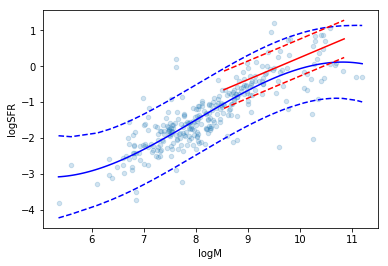

In [293]:
from scipy.io.idl import readsav
lvls = readsav('lvlsz.sav')['lvls']
tempx = [np.log10(x[11]) for x in lvls]
tempy = [np.log10(x[9]) for x in lvls]
lvls = pd.DataFrame({'logM': tempx, 'logSFR': tempy})
ax = lvls.plot.scatter('logM', 'logSFR', alpha=0.2)
lm = smf.ols(formula='logSFR ~ logM + np.power(logM, 2) + np.power(logM, 3)', data=lvls).fit()
print(lm.summary())
X_plot = np.linspace(min(lvls['logM']), max(lvls['logM']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]+ X_plot**3*lm.params[3]
ax.plot(X_plot, Y_plot, color='blue')
sfsq['lvl_x'] = [x for x in X_plot]
sfsq['lvl_y'] = [y for y in Y_plot]

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(lvls['logM'], iv_u)
lower = zip(lvls['logM'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'b--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'b--')
sfsq['lvl_ux'] = [x[0] for x in upper_sorted]
sfsq['lvl_uy'] = [x[1] for x in upper_sorted]
sfsq['lvl_lx'] = [x[0] for x in lower_sorted]
sfsq['lvl_ly'] = [x[1] for x in lower_sorted]

ax.plot(sfsq['sdss_ux'], sfsq['sdss_uy'], 'r--')
ax.plot(sfsq['sdss_lx'], sfsq['sdss_ly'], 'r--')
ax.plot(sfsq['sdss_x'], sfsq['sdss_y'], color='red')

Note that the SDSS sample contains only SF galaxies (red), so that is biased against the LVL galaxies (blue)!

Use the following file to overlay the SF sequence of SDSS and LVL galaxies on the plots!

In [294]:
file5 = open('sfsq.txt', 'w')
for key in sfsq.keys():
    file5.write('\n'+key+'\n')
    file5.write(str(sfsq[key]))
file5.close()

In [295]:
# read the values from intervals.txt into a dictionary for plotting purpose
test = {}
file5 = open('sfsq.txt', 'r')
lines = file5.readlines()
flag = 0
for line in lines:
    if re.search(r'[a-zA-Z]+_[a-zA-Z]+', line):
        key = line[:-1]
        flag = 0
    if line.startswith('['):
        line = line[1:-2]
        vals = line.split(r', ')
        vals = [float(val) for val in vals]
        flag = 1
    if flag:
        test[key] = vals
print(test.keys())
file5.close()

['sdss_ly', 'sdss_lx', 'lvl_ly', 'lvl_lx', 'sdss_ux', 'sdss_uy', 'lvl_ux', 'lvl_uy', 'lvl_x', 'lvl_y', 'sdss_x', 'sdss_y']


## Metallicity vs. sSFRs

                            OLS Regression Results                            
Dep. Variable:          p50_PP04_O3N2   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     161.4
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           7.20e-54
Time:                        10:28:22   Log-Likelihood:                 390.49
No. Observations:                 464   AIC:                            -775.0
Df Residuals:                     461   BIC:                            -762.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

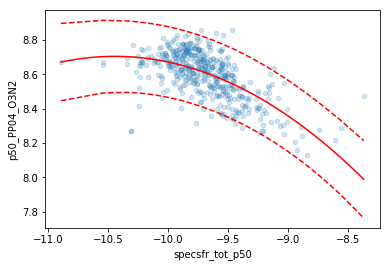

In [296]:
ohsq = {}
result = temp

result = result[result['specsfr_tot_p50'] != -9999.] # eliminate the ones very invalid sSFRs
ax = result.plot.scatter('specsfr_tot_p50', 'p50_PP04_O3N2', alpha=0.2)
lm = smf.ols(formula='p50_PP04_O3N2 ~ specsfr_tot_p50 + np.power(specsfr_tot_p50, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['specsfr_tot_p50']), max(result['specsfr_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['specsfr_tot_p50'], iv_u)
lower = zip(result['specsfr_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

ohsq['PP04_x'] = [x for x in X_plot]
ohsq['PP04_y'] = [y for y in Y_plot]
ohsq['PP04_ux'] = [x[0] for x in upper_sorted]
ohsq['PP04_uy'] = [x[1] for x in upper_sorted]
ohsq['PP04_lx'] = [x[0] for x in lower_sorted]
ohsq['PP04_ly'] = [x[1] for x in lower_sorted]



ax = result.plot.scatter('specsfr_tot_p50', 'p50_D13_N2S2_O3S2', alpha=0.2)
lm = smf.ols(formula='p50_D13_N2S2_O3S2 ~ specsfr_tot_p50 + np.power(specsfr_tot_p50, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['specsfr_tot_p50']), max(result['specsfr_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['specsfr_tot_p50'], iv_u)
lower = zip(result['specsfr_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

ohsq['D13_x'] = [x for x in X_plot]
ohsq['D13_y'] = [y for y in Y_plot]
ohsq['D13_ux'] = [x[0] for x in upper_sorted]
ohsq['D13_uy'] = [x[1] for x in upper_sorted]
ohsq['D13_lx'] = [x[0] for x in lower_sorted]
ohsq['D13_ly'] = [x[1] for x in lower_sorted]


                            OLS Regression Results                            
Dep. Variable:           p50_KD02comb   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     86.93
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           9.27e-33
Time:                        10:28:22   Log-Likelihood:                 317.42
No. Observations:                 464   AIC:                            -628.8
Df Residuals:                     461   BIC:                            -616.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

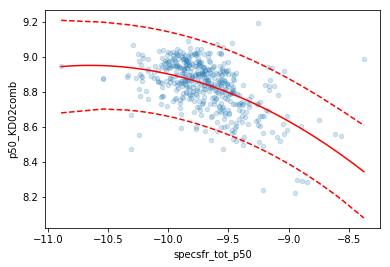

In [297]:
ax = result.plot.scatter('specsfr_tot_p50', 'p50_KD02comb', alpha=0.2)
lm = smf.ols(formula='p50_KD02comb ~ specsfr_tot_p50 + np.power(specsfr_tot_p50, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['specsfr_tot_p50']), max(result['specsfr_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['specsfr_tot_p50'], iv_u)
lower = zip(result['specsfr_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

ohsq['KD02_x'] = [x for x in X_plot]
ohsq['KD02_y'] = [y for y in Y_plot]
ohsq['KD02_ux'] = [x[0] for x in upper_sorted]
ohsq['KD02_uy'] = [x[1] for x in upper_sorted]
ohsq['KD02_lx'] = [x[0] for x in lower_sorted]
ohsq['KD02_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:           p50_M08_N2Ha   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     158.7
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           3.54e-53
Time:                        10:28:22   Log-Likelihood:                 371.06
No. Observations:                 464   AIC:                            -736.1
Df Residuals:                     461   BIC:                            -723.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

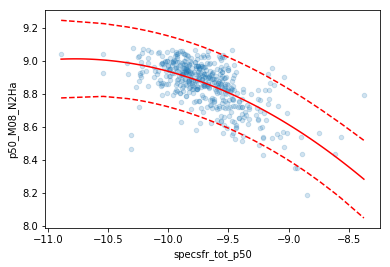

In [298]:
result = result[result['p50_M08_N2Ha'] < 9.2]
ax = result.plot.scatter('specsfr_tot_p50', 'p50_M08_N2Ha', alpha=0.2)
lm = smf.ols(formula='p50_M08_N2Ha ~ specsfr_tot_p50 + np.power(specsfr_tot_p50, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['specsfr_tot_p50']), max(result['specsfr_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['specsfr_tot_p50'], iv_u)
lower = zip(result['specsfr_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

ohsq['M08_x'] = [x for x in X_plot]
ohsq['M08_y'] = [y for y in Y_plot]
ohsq['M08_ux'] = [x[0] for x in upper_sorted]
ohsq['M08_uy'] = [x[1] for x in upper_sorted]
ohsq['M08_lx'] = [x[0] for x in lower_sorted]
ohsq['M08_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:           p50_M13_O3N2   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     145.5
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           1.13e-49
Time:                        10:28:22   Log-Likelihood:                 575.89
No. Observations:                 462   AIC:                            -1146.
Df Residuals:                     459   BIC:                            -1133.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

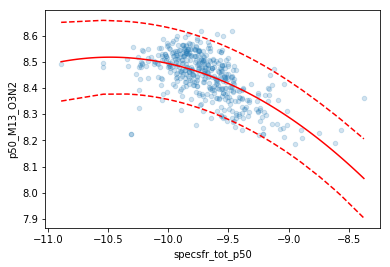

In [299]:
result = result[result['p50_M13_O3N2'] < 9.2]
ax = result.plot.scatter('specsfr_tot_p50', 'p50_M13_O3N2', alpha=0.2)
lm = smf.ols(formula='p50_M13_O3N2 ~ specsfr_tot_p50 + np.power(specsfr_tot_p50, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['specsfr_tot_p50']), max(result['specsfr_tot_p50']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['specsfr_tot_p50'], iv_u)
lower = zip(result['specsfr_tot_p50'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

ohsq['M13_x'] = [x for x in X_plot]
ohsq['M13_y'] = [y for y in Y_plot]
ohsq['M13_ux'] = [x[0] for x in upper_sorted]
ohsq['M13_uy'] = [x[1] for x in upper_sorted]
ohsq['M13_lx'] = [x[0] for x in lower_sorted]
ohsq['M13_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:               logOHp12   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     11.02
Date:                Mon, 11 Jun 2018   Prob (F-statistic):            0.00114
Time:                        10:28:23   Log-Likelihood:                -85.335
No. Observations:                 144   AIC:                             174.7
Df Residuals:                     142   BIC:                             180.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0224      0.664      9.070      0.0

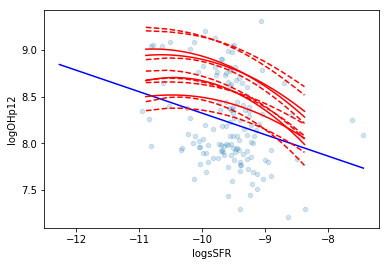

In [300]:
lvls = readsav('lvlsz.sav')['lvls']
tempx = np.array([np.log10(x[11]) for x in lvls])
tempy = np.array([np.log10(x[9]) for x in lvls])
tempz = np.array([x[12] for x in lvls])
lvls = pd.DataFrame({'logM': tempx, 'logsSFR': (tempy-tempx), 'logOHp12': tempz})
ax = lvls.plot.scatter('logsSFR', 'logOHp12', alpha=0.2)

lm = smf.ols(formula='logOHp12 ~ logsSFR', data=lvls).fit()
print(lm.summary())
X_plot = np.linspace(min(lvls['logsSFR']), max(lvls['logsSFR']), 2)
Y_plot = lm.params[0] + X_plot*lm.params[1]
ax.plot(X_plot, Y_plot, color='blue')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(lvls['logsSFR'], iv_u)
lower = zip(lvls['logsSFR'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

#ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'b--')
#ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'b--')

ohsq['lvl_x'] = [x for x in X_plot]
ohsq['lvl_y'] = [y for y in Y_plot]
ohsq['lvl_ux'] = [x[0] for x in upper_sorted]
ohsq['lvl_uy'] = [x[1] for x in upper_sorted]
ohsq['lvl_lx'] = [x[0] for x in lower_sorted]
ohsq['lvl_ly'] = [x[1] for x in lower_sorted]

#ax.plot(ohsq['D13_ux'], ohsq['D13_uy'], 'r--')
#ax.plot(ohsq['D13_lx'], ohsq['D13_ly'], 'r--')
#ax.plot(ohsq['D13_x'], ohsq['D13_y'], color='red')

ax.plot(ohsq['KD02_ux'], ohsq['KD02_uy'], 'r--')
ax.plot(ohsq['KD02_lx'], ohsq['KD02_ly'], 'r--')
ax.plot(ohsq['KD02_x'], ohsq['KD02_y'], color='red')

ax.plot(ohsq['M08_ux'], ohsq['M08_uy'], 'r--')
ax.plot(ohsq['M08_lx'], ohsq['M08_ly'], 'r--')
ax.plot(ohsq['M08_x'], ohsq['M08_y'], color='red')

ax.plot(ohsq['PP04_ux'], ohsq['PP04_uy'], 'r--')
ax.plot(ohsq['PP04_lx'], ohsq['PP04_ly'], 'r--')
ax.plot(ohsq['PP04_x'], ohsq['PP04_y'], color='red')

ax.plot(ohsq['M13_ux'], ohsq['M13_uy'], 'r--')
ax.plot(ohsq['M13_lx'], ohsq['M13_ly'], 'r--')
ax.plot(ohsq['M13_x'], ohsq['M13_y'], color='red')

In [301]:
file6 = open('ohsq.txt', 'w')
for key in ohsq.keys():
    file6.write('\n'+key+'\n')
    file6.write(str(ohsq[key]))
file6.close()

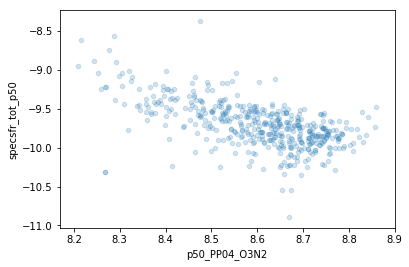

In [302]:
ax = result.plot.scatter('p50_PP04_O3N2', 'specsfr_tot_p50', alpha=0.2)

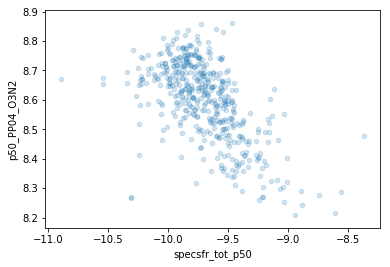

In [303]:
ax = result.plot.scatter('specsfr_tot_p50', 'p50_PP04_O3N2', alpha=0.2)

## sSFR vs. Metallicity

                            OLS Regression Results                            
Dep. Variable:        specsfr_tot_p50   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     144.4
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           2.09e-49
Time:                        10:28:23   Log-Likelihood:                 9.5940
No. Observations:                 464   AIC:                            -13.19
Df Residuals:                     461   BIC:                           -0.7684
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

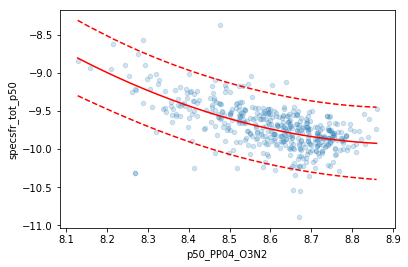

In [304]:
sSFRsq = {}
result = temp

result = result[result['specsfr_tot_p50'] != -9999.] # eliminate the ones very invalid sSFRs
ax = result.plot.scatter('p50_PP04_O3N2', 'specsfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='specsfr_tot_p50 ~ p50_PP04_O3N2 + np.power(p50_PP04_O3N2, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['p50_PP04_O3N2']), max(result['p50_PP04_O3N2']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['p50_PP04_O3N2'], iv_u)
lower = zip(result['p50_PP04_O3N2'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sSFRsq['PP04_x'] = [x for x in X_plot]
sSFRsq['PP04_y'] = [y for y in Y_plot]
sSFRsq['PP04_ux'] = [x[0] for x in upper_sorted]
sSFRsq['PP04_uy'] = [x[1] for x in upper_sorted]
sSFRsq['PP04_lx'] = [x[0] for x in lower_sorted]
sSFRsq['PP04_ly'] = [x[1] for x in lower_sorted]



ax = result.plot.scatter('p50_D13_N2S2_O3S2', 'specsfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='specsfr_tot_p50 ~ p50_D13_N2S2_O3S2 + np.power(p50_D13_N2S2_O3S2, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['p50_D13_N2S2_O3S2']), max(result['p50_D13_N2S2_O3S2']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['p50_D13_N2S2_O3S2'], iv_u)
lower = zip(result['p50_D13_N2S2_O3S2'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sSFRsq['D13_x'] = [x for x in X_plot]
sSFRsq['D13_y'] = [y for y in Y_plot]
sSFRsq['D13_ux'] = [x[0] for x in upper_sorted]
sSFRsq['D13_uy'] = [x[1] for x in upper_sorted]
sSFRsq['D13_lx'] = [x[0] for x in lower_sorted]
sSFRsq['D13_ly'] = [x[1] for x in lower_sorted]


                            OLS Regression Results                            
Dep. Variable:        specsfr_tot_p50   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     82.29
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           2.74e-31
Time:                        10:28:24   Log-Likelihood:                -32.396
No. Observations:                 464   AIC:                             70.79
Df Residuals:                     461   BIC:                             83.21
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

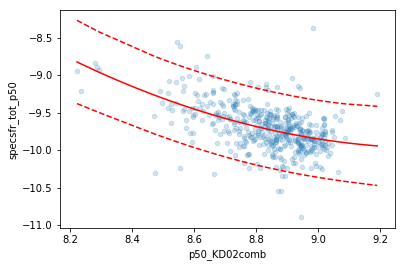

In [305]:
ax = result.plot.scatter('p50_KD02comb', 'specsfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='specsfr_tot_p50 ~ p50_KD02comb + np.power(p50_KD02comb, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['p50_KD02comb']), max(result['p50_KD02comb']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['p50_KD02comb'], iv_u)
lower = zip(result['p50_KD02comb'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sSFRsq['KD02_x'] = [x for x in X_plot]
sSFRsq['KD02_y'] = [y for y in Y_plot]
sSFRsq['KD02_ux'] = [x[0] for x in upper_sorted]
sSFRsq['KD02_uy'] = [x[1] for x in upper_sorted]
sSFRsq['KD02_lx'] = [x[0] for x in lower_sorted]
sSFRsq['KD02_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:        specsfr_tot_p50   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     144.0
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           2.60e-49
Time:                        10:28:24   Log-Likelihood:                 9.3753
No. Observations:                 464   AIC:                            -12.75
Df Residuals:                     461   BIC:                           -0.3309
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

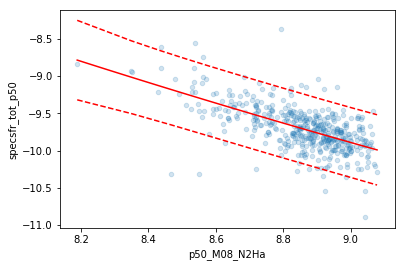

In [306]:
result = result[result['p50_M08_N2Ha'] < 9.2]
ax = result.plot.scatter('p50_M08_N2Ha', 'specsfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='specsfr_tot_p50 ~ p50_M08_N2Ha + np.power(p50_M08_N2Ha, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['p50_M08_N2Ha']), max(result['p50_M08_N2Ha']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['p50_M08_N2Ha'], iv_u)
lower = zip(result['p50_M08_N2Ha'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sSFRsq['M08_x'] = [x for x in X_plot]
sSFRsq['M08_y'] = [y for y in Y_plot]
sSFRsq['M08_ux'] = [x[0] for x in upper_sorted]
sSFRsq['M08_uy'] = [x[1] for x in upper_sorted]
sSFRsq['M08_lx'] = [x[0] for x in lower_sorted]
sSFRsq['M08_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:        specsfr_tot_p50   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     132.1
Date:                Mon, 11 Jun 2018   Prob (F-statistic):           4.93e-46
Time:                        10:28:24   Log-Likelihood:                 8.5634
No. Observations:                 462   AIC:                            -11.13
Df Residuals:                     459   BIC:                             1.280
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

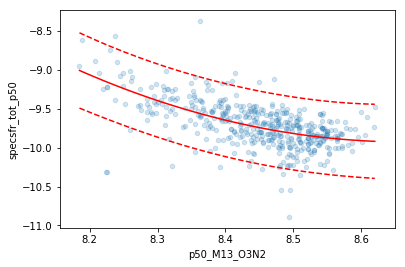

In [307]:
result = result[result['p50_M13_O3N2'] < 9.2] # eliminate the ones very invalid sSFRs
ax = result.plot.scatter('p50_M13_O3N2', 'specsfr_tot_p50', alpha=0.2)
lm = smf.ols(formula='specsfr_tot_p50 ~ p50_M13_O3N2 + np.power(p50_M13_O3N2, 2)', data=result).fit()
print(lm.summary())
X_plot = np.linspace(min(result['p50_M13_O3N2']), max(result['p50_M13_O3N2']), 100)
Y_plot = lm.params[0] + X_plot*lm.params[1] + X_plot**2*lm.params[2]
ax.plot(X_plot, Y_plot, color='red')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(result['p50_M13_O3N2'], iv_u)
lower = zip(result['p50_M13_O3N2'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'r--')
ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'r--')

sSFRsq['M13_x'] = [x for x in X_plot]
sSFRsq['M13_y'] = [y for y in Y_plot]
sSFRsq['M13_ux'] = [x[0] for x in upper_sorted]
sSFRsq['M13_uy'] = [x[1] for x in upper_sorted]
sSFRsq['M13_lx'] = [x[0] for x in lower_sorted]
sSFRsq['M13_ly'] = [x[1] for x in lower_sorted]

                            OLS Regression Results                            
Dep. Variable:                logsSFR   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     11.02
Date:                Mon, 11 Jun 2018   Prob (F-statistic):            0.00114
Time:                        10:28:24   Log-Likelihood:                -107.49
No. Observations:                 144   AIC:                             219.0
Df Residuals:                     142   BIC:                             224.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.9909      0.777     -9.003      0.0

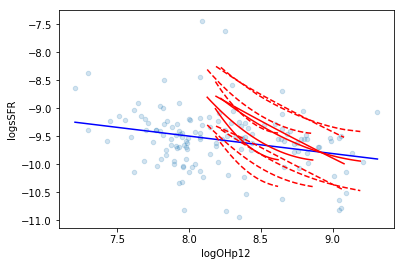

In [308]:
lvls = readsav('lvlsz.sav')['lvls']
tempx = np.array([np.log10(x[11]) for x in lvls])
tempy = np.array([np.log10(x[9]) for x in lvls])
tempz = np.array([x[12] for x in lvls])
lvls = pd.DataFrame({'logM': tempx, 'logsSFR': (tempy-tempx), 'logOHp12': tempz})
ax = lvls.plot.scatter('logOHp12', 'logsSFR', alpha=0.2)

lm = smf.ols(formula='logsSFR ~ logOHp12', data=lvls).fit()
print(lm.summary())
X_plot = np.linspace(min(lvls['logOHp12']), max(lvls['logOHp12']), 2)
Y_plot = lm.params[0] + X_plot*lm.params[1]
ax.plot(X_plot, Y_plot, color='blue')

prstd, iv_l, iv_u = wls_prediction_std(lm)
upper = zip(lvls['logOHp12'], iv_u)
lower = zip(lvls['logOHp12'], iv_l)
upper_sorted = sorted(upper, key=lambda k:k[0])
lower_sorted = sorted(lower, key=lambda k:k[0])

#ax.plot([x[0] for x in upper_sorted], [x[1] for x in upper_sorted], 'b--')
#ax.plot([x[0] for x in lower_sorted], [x[1] for x in lower_sorted], 'b--')

sSFRsq['lvl_x'] = [x for x in X_plot]
sSFRsq['lvl_y'] = [y for y in Y_plot]
sSFRsq['lvl_ux'] = [x[0] for x in upper_sorted]
sSFRsq['lvl_uy'] = [x[1] for x in upper_sorted]
sSFRsq['lvl_lx'] = [x[0] for x in lower_sorted]
sSFRsq['lvl_ly'] = [x[1] for x in lower_sorted]

#ax.plot(sSFRsq['D13_ux'], sSFRsq['D13_uy'], 'r--')
#ax.plot(sSFRsq['D13_lx'], sSFRsq['D13_ly'], 'r--')
#ax.plot(sSFRsq['D13_x'], sSFRsq['D13_y'], color='red')

ax.plot(sSFRsq['KD02_ux'], sSFRsq['KD02_uy'], 'r--')
ax.plot(sSFRsq['KD02_lx'], sSFRsq['KD02_ly'], 'r--')
ax.plot(sSFRsq['KD02_x'], sSFRsq['KD02_y'], color='red')

ax.plot(sSFRsq['M08_ux'], sSFRsq['M08_uy'], 'r--')
ax.plot(sSFRsq['M08_lx'], sSFRsq['M08_ly'], 'r--')
ax.plot(sSFRsq['M08_x'], sSFRsq['M08_y'], color='red')

ax.plot(sSFRsq['PP04_ux'], sSFRsq['PP04_uy'], 'r--')
ax.plot(sSFRsq['PP04_lx'], sSFRsq['PP04_ly'], 'r--')
ax.plot(sSFRsq['PP04_x'], sSFRsq['PP04_y'], color='red')

ax.plot(sSFRsq['M13_ux'], sSFRsq['M13_uy'], 'r--')
ax.plot(sSFRsq['M13_lx'], sSFRsq['M13_ly'], 'r--')
ax.plot(sSFRsq['M13_x'], sSFRsq['M13_y'], color='red')

In [309]:
file7 = open('sSFRsq.txt', 'w')
for key in sSFRsq.keys():
    file7.write('\n'+key+'\n')
    file7.write(str(sSFRsq[key]))
file7.close()

In [310]:
result

,specObjID,plateid,mjd,fiberid,z,z_err,z_warning,oii_flux,oii_flux_err,h_gamma_flux,...,p84_KD02comb,p50_PP04_O3N2,p16_PP04_O3N2,p84_PP04_O3N2,p50_M08_N2Ha,p16_M08_N2Ha,p84_M08_N2Ha,p50_M13_O3N2,p16_M13_O3N2,p84_M13_O3N2
0,1379315118239672320,1225,52760,319,0.086391,0.000010,0,93.40969,8.266558,29.11529,...,0.030,8.670,0.013,0.014,9.034,0.017,0.018,8.493,0.013,0.014
1,680098554194192384,604,52079,200,0.069204,0.000005,0,456.90930,14.822810,80.63847,...,0.016,8.542,0.005,0.005,8.829,0.008,0.009,8.408,0.006,0.006
2,472953583688509440,420,51871,275,0.040612,0.000007,0,133.15340,9.322999,15.93581,...,0.062,8.357,0.014,0.013,8.546,0.030,0.027,8.284,0.010,0.009
3,693703091391850496,616,52374,541,0.044110,0.000010,0,143.96140,13.413150,21.76315,...,0.043,8.595,0.019,0.017,8.865,0.028,0.032,8.442,0.014,0.014
4,642980969258706944,571,52286,335,0.066167,0.000008,0,96.99915,5.471032,33.54151,...,0.016,8.785,0.012,0.014,8.999,0.011,0.011,8.570,0.016,0.017
5,2343069230716446720,2081,53357,260,0.041647,0.000013,0,131.21530,14.157850,32.10155,...,0.028,8.616,0.011,0.012,8.990,0.022,0.024,8.456,0.011,0.011
6,2922912919681263616,2596,54207,279,0.044339,0.000007,0,320.45570,18.548450,99.73791,...,0.013,8.691,0.005,0.006,9.024,0.010,0.011,8.507,0.011,0.011
7,2654992715439171584,2358,53797,439,0.083683,0.000007,0,526.83080,10.572280,77.25859,...,0.014,8.502,0.004,0.004,8.766,0.007,0.007,8.380,0.004,0.005
8,1527950678092179456,1357,53034,380,0.072448,0.000007,0,189.95880,5.871387,37.16771,...,0.020,8.624,0.008,0.008,8.866,0.011,0.011,8.461,0.009,0.010
9,995372798169868288,884,52374,281,0.083244,0.000007,0,236.08570,23.016780,46.91667,...,0.027,8.594,0.007,0.007,8.820,0.010,0.010,8.441,0.008,0.009
